In [1]:
### - import all the usual stuff - ###

import sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

import gw150814_simulator as gs
from gw150814_simulator import GW150814, defaults, GW150814_Additive
# import module

import torch
torch.set_float32_matmul_precision('medium')
import numpy as np
import scipy
from scipy.signal import welch
import scipy.stats
import pytorch_lightning as pl
from collections import defaultdict
from tqdm import tqdm
import jax.numpy as jnp
import plotfancy as pf
pf.housestyle_rcparams()

from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

from ipywidgets import interactive_output, VBox, HBox, FloatSlider, Checkbox, FloatLogSlider, FloatRangeSlider, FloatText, IntSlider
import sounddevice as sd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import os, sys

from simulators.additive import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

In [5]:
### import the comb function ###
from src.utils.comb import Comb
from src.utils.comb2 import Comb2

In [ ]:
gps = event_gps('GW150914')
strain_data = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)

def plot_interactive_comb(df, f0, nf):

    sample_rate = strain_data.sample_rate.value
    base_for_comb = np.zeros(len(strain_data.value))

    # global extras
    # freqs, psd_comb, _, comb_timeseries, _, extras = Comb(
    #     strain_data=base_for_comb,
    #     sample_rate=sample_rate,
    #     f0=f0,
    #     df=df,
    #     nf=int(nf),
    #     amplitude=1e-21 
    # )

    psd_noise, psd_with_comb, freqs, comb_ts = Comb2(
            sample_rate=sample_rate,
            f0=f0,
            df=df,
            nf=nf,
            amplitude_factor=1e4, # Make peaks very prominent for plotting
            duration=4
        )

    ### --- Plotting --- ###
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
    fig.suptitle("Interactive LIGO Comb Plotter", fontsize=16)

    background_psd = strain_data.psd(fftlength=4)
    global grid
    grid = np.linspace(np.max(freqs), np.min(freqs), len(extras[2]))
    
    # ax1.loglog(background_psd.frequencies, background_psd, label="LIGO Background Noise (L1)", color='black', alpha=0.7)
    # ax1.loglog(freqs, psd_comb, label="Injected Comb Signal", color='red', lw=2)

    ax1.loglog(freqs, psd_noise, label="LIGO Background Noise (L1)", color='black', alpha=0.7)
    ax1.loglog(freqs, psd_with_comb, label="Injected Comb Signal", color='red', lw=2,zorder=-2)


    ax1.set_title("Power Spectral Density")
    ax1.set_xlabel("Frequency (Hz)")
    ax1.set_ylabel("PSD (strain$^2$/Hz)")
    ax1.legend()
    ax1.grid(True, which="both", ls=":")
    ax1.set_xlim(20, 1024)
    ax1.set_ylim(1e-48, 1e-38)

    # time_axis = np.arange(len(comb_timeseries)) / sample_rate
    # ax2.plot(time_axis, comb_timeseries, label="Comb Timeseries", color='blue')

    ax2.plot(comb_ts)
    ax2.set_title("Generated Comb Signal (Time Domain)")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Strain")
    ax2.legend()
    # ax2.set_xlim(0, 0.2) # Zoom in to see the waveform
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    pf.fix_plot([ax1,ax2])
    plt.show()

df_slider = FloatSlider(min=5, max=100, step=1, value=25, description='df (Hz)')
f0_slider = FloatSlider(min=20, max=200, step=1, value=50, description='f0 (Hz)')
nf_slider = IntSlider(min=1, max=50, step=1, value=10, description='nf (count)')

interactive_plot = interactive_output(
    plot_interactive_comb, 
    {'df': df_slider, 'f0': f0_slider, 'nf': nf_slider}
)

from IPython.display import display
ui = VBox([df_slider, f0_slider, nf_slider, interactive_plot])
display(ui)

In [ ]:
extras

[array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       shape=(2097153,)),
 array([0.+0.j, 0.+0.j, 0.-0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       shape=(2097153,)),
 array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       shape=(2097153,))]

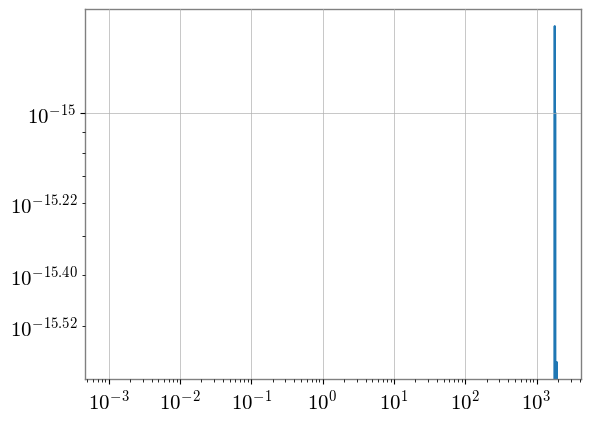

In [ ]:
plt.loglog(grid,np.real(extras[2]))